# VOLATILITY IS ALL YOU NEED

## Requirements

In [1]:
# Import all required libraries
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import matplotlib as mpl
i = complex(0,1)
np.random.seed(8309)

# Import all functions from custom modules
from Load_data_yfiance import get_Today_data, save_to_csv, read_from_csv
from plot_loc_vol_surface import plot_local_vol_surface
from heston import heston_simulation, fit_Heston_model
from garch import Garch_simulation,get_param_garch
from dupire import dupire_local_vol, dupire_simulation, get_spline
from BaseLineGBM import GBM_simulation
from plot_result import plot_s_paths,plot_v_paths,plot_log_norm,plot_CI,plot_sharkfin,valuation
from greeks import plot_greeks
from Fit_interp_regres import get_interp
from plot_2_interp import plot_two_interp
from Imp_vol import imp_vol_simulation

## Load Data

In [2]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #正常显示负号
pd.set_option('display.max_columns',6)
pd.set_option('display.max_rows',6)
data_raw = pd.read_pickle("DataSet/sse50_option_data_processed_20231110.pkl")
data_raw["w"] = data_raw["market_imp_vol"]**2 * data_raw["maturity"]  #计算总方差
data_raw["y"] = np.log(data_raw["exerciseprice"]/data_raw["F"])  #计算远期在值程度
calls = data_raw.sort_values(["contract_month","y"])
r = 0.045

calls = calls.rename(columns={
    'exerciseprice': 'strike',
    'settlement_price': 'lastPrice',    
    'maturity': 'ttm',
    '实虚值': 'in_out',
    'market_imp_vol': 'imp_vol'
})
calls["in_out"] = calls["in_out"].replace("虚值", "out")
calls["in_out"] = calls["in_out"].replace("实值", "in")


print("range of strike: ",calls["strike"].min(),calls["strike"].max())
print("range of Moneyness: ",calls["y"].min(),calls["y"].max())
print("range of ttm: ",calls["ttm"].min(),calls["ttm"].max())
print("number of options: ",calls.size)

calls = calls.dropna()
# use calls_out for parameter calibration
calls_out = calls[calls["in_out"] == "out"].copy()
calls.head()

range of strike:  2.25 2.95
range of Moneyness:  -0.1220606967140722 0.16499252052151342
range of ttm:  0.049586776859504134 0.9462809917355371
number of options:  1802


,date,tradecode,strike,...,imp_vol,w,y
82,2023-11-10,510050P2311M02250,2.25,...,0.184617,0.001690,-0.102433
83,2023-11-10,510050P2311M02300,2.30,...,0.156664,0.001217,-0.080454
78,2023-11-10,510050C2311M02350,2.35,...,0.137044,0.000931,-0.058948
79,2023-11-10,510050P2311M02350,2.35,...,0.143891,0.001027,-0.058948
60,2023-11-10,510050C2311M02400,2.40,...,0.121253,0.000729,-0.037895


In [3]:
intrep,reg = get_interp(calls)
plot_two_interp(intrep,reg,calls)

# Methods

## Local Volitality Method

### Get Interpolation and Regression (as comparison)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import matplotlib as mpl

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #正常显示负号
pd.set_option('display.max_columns',6)
pd.set_option('display.max_rows',6)
data_raw = pd.read_pickle("DataSet/sse50_option_data_processed_20231110.pkl")
data_raw["w"] = data_raw["market_imp_vol"]**2 * data_raw["maturity"]  #计算总方差
data_raw["y"] = np.log(data_raw["exerciseprice"]/data_raw["F"])  #计算远期在值程度
option = data_raw.loc[data_raw["实虚值"]=="虚值"]  #后续主要使用虚值期权拟合
option = option.sort_values(["contract_month","y"])


option = option.rename(columns={
    # 'exerciseprice': 'strike',
    'settlement_price': 'lastPrice',    
    'maturity': 'ttm',
    '实虚值': 'in_out',
    'market_imp_vol': 'imp_vol'
})
option["in_out"] = option["in_out"].replace("虚值", "out")
option["in_out"] = option["in_out"].replace("实值", "in")

spline = get_spline(calls)
local_vol_surface = dupire_local_vol(calls,spline,n_t=15,n_y=20)
plot_local_vol_surface(calls,local_vol_surface)

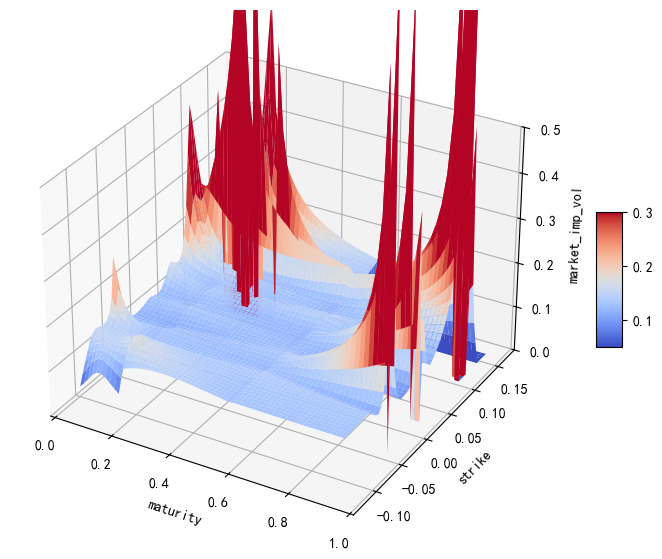

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
import matplotlib as mpl

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #正常显示负号
pd.set_option('display.max_columns',6)
pd.set_option('display.max_rows',6)

data_raw = pd.read_pickle("DataSet/sse50_option_data_processed_20231110.pkl")

data_raw["w"] = data_raw["market_imp_vol"]**2 * data_raw["maturity"]  #计算总方差
data_raw["y"] = np.log(data_raw["exerciseprice"]/data_raw["F"])  #计算远期在值程度
option = data_raw.loc[data_raw["实虚值"]=="虚值"]  #后续主要使用虚值期权拟合
option = option.sort_values(["contract_month","y"])
option
def get_spline(data):  #用来事先计算好4个期限的样条函数值，后续就不用反复计算了
    spline = []
    for m in data["maturity"].unique():
        moneyness = data.loc[data["maturity"] == m]["y"]
        sample_volatility = data.loc[data["maturity"] == m]["w"]
        cs_k = CubicSpline(x = moneyness,y = sample_volatility,extrapolate=True)
        spline.append(cs_k)
    return spline
spline = get_spline(option)
def get_total_v(data,spline,y,t):
    total_v = [float(cs(y)) for cs in spline]
    f = interp1d(x =data["maturity"].unique(),y = total_v,kind = "linear",fill_value="extrapolate") #平远期插值相当于总方差的线性插值
    v = float(f(t))
    return v
def diff(data,spline,y,t):
    yt = get_total_v(data,spline,y,t)
    y_up = get_total_v(data,spline,y*(1+0.001),t)
    y_down = get_total_v(data,spline,y*(1-0.001),t)
    t_up = get_total_v(data,spline,y,t*(1+0.001))

    dw_dt = (t_up - yt)/(t*0.001)
    dw_dy = (y_up - y_down)/(y*0.001*2)
    dw_dy2 = (y_up + y_down - 2*yt)/(y*0.001)**2
    return dw_dt,dw_dy,dw_dy2
def local_v(data,spline,y,t):
    w = get_total_v(data,spline,y,t)
    dw_dt,dw_dy,dw_dy2 = diff(data,spline,y,t)
    numetator = dw_dt
    denonimator = 1-y/w*dw_dy + 0.25*(-0.25 - 1/w + y**2/w**2) * (dw_dy**2) + 0.5* dw_dy2
    local_variance = numetator / denonimator
    if local_variance < 0:  #若存在套利机会，很可能会出现算出的结果为负数，这里简单处理一下
        local_variance  = 1e-8
    return np.sqrt(local_variance)
def plot_ivs(t,k,v):
    fig = plt.figure(figsize=(12, 7))
    ax = plt.axes(projection='3d')
    norm = mpl.colors.Normalize(vmin=0.05, vmax=0.3)
    # 绘图主程序
    surf = ax.plot_surface(t, k, v, rstride=1, cstride=1,
    cmap=plt.cm.coolwarm,norm = norm,linewidth=0.5, antialiased=True)
    # 设置坐标轴
    ax.set_xlabel('maturity')
    ax.set_ylabel('strike')
    ax.set_zlabel('market_imp_vol')
    ax.set_zlim((0,0.5))
    fig.colorbar(surf, shrink=0.25, aspect=5)
def get_local_variance(data,spline):
    t_array = np.linspace(data["maturity"].min(),data["maturity"].max(),60)
    y_array = np.linspace(data["y"].min(),data["y"].max(),60)   
    t, y = np.meshgrid(t_array,y_array) 
    v = np.zeros_like(y)

    # 循环确定每个点的隐含波动率，上一步已经存储了k维度上的样条函数，循环的时候还需要t维度的样条插值，这样可以计算任意点的隐含波动率值
    for t_idx,t1 in enumerate(t_array):

        for y_idx,y1 in enumerate(y_array):
            v[y_idx,t_idx] = local_v(data,spline,y1,t1)
    return t,y,v
t,y,v = get_local_variance(option,spline)
plot_ivs(t,y,v)